<p align="center"><img src='https://drive.google.com/uc?export=view&id=1Q3X1N08GMDGuKZq_2Kh7ADqYFEdddg17'></p>

# **Analyse exploratroire de donn√©es**

# 1 Preliminary

## 1.1 Context

La poule qui chante est une entreprise fran√ßaise d‚Äôagroalimentaire qui souhaite se d√©velopper √† l'international. L'entreprise n'a pas encore identifier aucun pays ni aucun continent particuliers pour son d√©veloppement. L'objectif de ce travail est de faire une √©tude de march√© en proposant √† l‚Äôentreprise une premi√®re analyse des groupements de pays qu'elle peut cibler pour exporter ses produits.

L'√©tude se fait en deux parties, la premi√®re vise √† proposer une premi√®re analyse exploratoire de donn√©es. La seconde utilise des algorithmes d'apprentissage non supervis√©, y compris la classification et le clustering pour segmenter les pays.

Dans ce notebook, nous allons surtout nettoyer les donn√©es, s√©lectionner les variables qui semblent pertinentes, faire une analyse univari√©e et multivari√©e et puis appliquer quelques transformations de donn√©es si n√©cessaire.

## 1.2 Libraries

In [1]:
import pandas as pd
import numpy as np
from math import radians

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics.pairwise import haversine_distances

import scipy.stats as st

import matplotlib.pyplot as plt

import seaborn as sns

from statsmodels.graphics.gofplots import qqplot

## 1.3 Options

In [2]:
# Modifier un parametrage du pandas
pd.options.display.max_columns=999
# Afficher des d√©cimaux sans format scientifique
pd.options.display.float_format = '{:.3f}'.format
# Identifier les valeurs qui seront consid√©r√©es comme nulles
missing_values = ["n/a", "na", "--","nan","NaN", "NaT", " ", ""]

## 1.4 Functions

In [3]:
# Calculer la distance entre paris et une destination
def distance_from_paris(latitude, longitude):
  paris = [49.0083899664, 2.53844117956]
  distination = [latitude, longitude]
  distination_in_radians = [radians(x) for x in distination]
  paris_in_radians = [radians(y) for y in paris]
  result = haversine_distances([distination_in_radians, paris_in_radians])
  result *= 6371000/1000  # multiplier par le rayon de la Terre pour obtenir des kilom√®tres
  return result[0][1]

In [4]:
# D√©tecter et lister les outliers d'un dataframe
def outliers_decector(df):
  outliers = {}
  outliers_list = []
  indexes_list = []
  variables_list = []
  
  for col in df.columns:
    var_outliers = {}
    
    q1 = df[col].quantile(0.25) # Calculer le premier quartile Q1
    q3 = df[col].quantile(0.75) # Calculer le troisi√®me quartile Q3
    iqr = q3 - q1 # Calculer l'√©cart interquartile IQR
    
    var_out = df[(df[col] < (q1 - 1.5 * iqr)) | (df[col]> (q3 + 1.5 * iqr))].index.to_list()
    
    if len(var_out) > 0:
      variables_list.append(col)
      var_outliers['var_name'] = col
      var_outliers['n_outliers'] = len(var_out)
      var_outliers['outliers'] = var_out
      outliers_list.append(var_outliers)   
      for e in var_out:
        if e not in indexes_list:
          indexes_list.append(e)

  outliers['n_outliers'] = len(indexes_list)
  outliers['indexes'] = indexes_list
  outliers['n_variables'] = len(variables_list)
  outliers['variables'] = variables_list
  outliers['list'] = outliers_list

  return outliers

In [5]:
# Tester graphiquement la distribution des varaibles d'un DataFrame
def normality_graphical_test(df):
  for col in df.columns:
    fig, axes = plt.subplots(1, 3, figsize = (8, 2))
    df[col].plot(kind='hist', ax = axes[0]);
    df[col].plot(kind='kde', ax = axes[1]);
    axes[0].set_title(col)
    axes[1].set_title(col)
    
    qqplot(df[col], line='s', ax = axes[2])
    plt.title(col)
    fig.tight_layout()
    plt.show()

In [6]:
# Tourner le test de normalit√© de D‚ÄôAgostino et Pearson
def dagostino_test(df, alpha):
  print(f"Test de D‚ÄôAgostino et Pearson (alpha = {alpha}) \n")
  for col in df.columns:
    s2k2, p = st.normaltest(df[col])
    print(f'Variable : {col}')
    print(f'R√©sultat : S2 + K2 = {round(s2k2, 4)}, p-value = {round(p, 4)}')
    if p > alpha:
      print('Interpr√©tation : la distribution semble normale (gaussienne) \n')
    else:
      print('Interpr√©tation : la distribution semble anormale (non gaussienne) \n')

In [7]:
# Tourner le test de normalit√© de Shapiro-Wilk
def shapiro_test(df, alpha):
  print(f"Test de Shapiro-Wilk (alpha = {alpha}) \n")
  for col in df.columns:
    w, p = st.shapiro(df[col])
    print(f'Variable : {col}')
    print(f'R√©sultat : w = {round(w, 4)}, p-value = {round(p, 4)}')
    if p > alpha:
      print('Interpr√©tation : la distribution semble normale (gaussienne) \n')
    else:
      print('Interpr√©tation : la distribution semble anormale (non gaussienne) \n')

# 2 Data Preparation

## 2.1 Data Loading

In [8]:
# Indicateur de disponibilit√© alimentaire
food_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/DisponibiliteAlimentaire_2017.csv", na_values = missing_values)

# Indicateur politique, Source : https://www.fao.org/faostat/fr/#data/FS
politic_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/FAOSTAT_POLI.csv", na_values = missing_values)

# Indicateur macro√©conomique, source : https://www.fao.org/faostat/fr/#data/MK
economic_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/FAOSTAT_MACRO.csv", na_values = missing_values)

# Indicateur d√©mographique, source : https://www.fao.org/faostat/fr/#data/MK
population_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/Population_2000_2018.csv", na_values = missing_values)

# Indicateur g√©ographique, Source : FAO + Google sheet Extension (Geoencoding by Awesome)
geocode_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/countries_geocoding.csv", na_values = missing_values)


## 2.2 Data Overview

In [9]:
food_df.head()

Code Domaine                      Domaine  Code zone         Zone  \
0          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
1          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
2          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
3          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
4          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   

   Code √âl√©ment                   √âl√©ment  Code Produit          Produit  \
0          5511                Production          2511  Bl√© et produits   
1          5611   Importations - Quantit√©          2511  Bl√© et produits   
2          5072        Variation de stock          2511  Bl√© et produits   
3          5911   Exportations - Quantit√©          2511  Bl√© et produits   
4          5301  Disponibilit√© int√©rieure          2511  Bl√© et produits   

   Code ann√©e  Ann√©e               Unit√©   Valeur Symbole  \
0        2017   2017  Milliers de tonnes 4281.000       S   
1        2017   2017  Milliers de tonnes 2302.000       S   
2        2017   2017  Milliers de tonnes -119.000       S   
3        2017   2017  Milliers de tonnes    0.000       S   
4        2017   2017  Milliers de tonnes 6701.000       S   

  Description du Symbole  
0  Donn√©es standardis√©es  
1  Donn√©es standardis√©es  
2  Donn√©es standardis√©es  
3  Donn√©es standardis√©es  
4  Donn√©es standardis√©es

In [10]:
food_df.tail()

Code Domaine                      Domaine  Code zone      Zone  \
176595          FBS  Nouveaux Bilans Alimentaire        181  Zimbabwe   
176596          FBS  Nouveaux Bilans Alimentaire        181  Zimbabwe   
176597          FBS  Nouveaux Bilans Alimentaire        181  Zimbabwe   
176598          FBS  Nouveaux Bilans Alimentaire        181  Zimbabwe   
176599          FBS  Nouveaux Bilans Alimentaire        181  Zimbabwe   

        Code √âl√©ment                                            √âl√©ment  \
176595          5142                                         Nourriture   
176596           645  Disponibilit√© alimentaire en quantit√© (kg/pers...   
176597           664     Disponibilit√© alimentaire (Kcal/personne/jour)   
176598           674  Disponibilit√© de prot√©ines en quantit√© (g/pers...   
176599           684  Disponibilit√© de mati√®re grasse en quantit√© (g...   

        Code Produit       Produit  Code ann√©e  Ann√©e               Unit√©  \
176595          2899  Miscellanees        2017   2017  Milliers de tonnes   
176596          2899  Miscellanees        2017   2017                  kg   
176597          2899  Miscellanees        2017   2017  Kcal/personne/jour   
176598          2899  Miscellanees        2017   2017     g/personne/jour   
176599          2899  Miscellanees        2017   2017     g/personne/jour   

        Valeur Symbole Description du Symbole  
176595  19.000       S  Donn√©es standardis√©es  
176596   1.330      Fc        Donn√©e calcul√©e  
176597   1.000      Fc        Donn√©e calcul√©e  
176598   0.040      Fc        Donn√©e calcul√©e  
176599   0.020      Fc        Donn√©e calcul√©e

In [11]:
food_df.shape

(176600, 14)

In [12]:
food_df.columns

Index(['Code Domaine', 'Domaine', 'Code zone', 'Zone', 'Code √âl√©ment',
       '√âl√©ment', 'Code Produit', 'Produit', 'Code ann√©e', 'Ann√©e', 'Unit√©',
       'Valeur', 'Symbole', 'Description du Symbole'],
      dtype='object')

In [13]:
food_df.dtypes

Code Domaine               object
Domaine                    object
Code zone                   int64
Zone                       object
Code √âl√©ment                int64
√âl√©ment                    object
Code Produit                int64
Produit                    object
Code ann√©e                  int64
Ann√©e                       int64
Unit√©                      object
Valeur                    float64
Symbole                    object
Description du Symbole     object
dtype: object

## 2.3 Data Cleaning

In [14]:
data = food_df.copy()

**Disponibilit√© alimentaire**

In [15]:
data.nunique()

Code Domaine                 1
Domaine                      1
Code zone                  174
Zone                       174
Code √âl√©ment                17
√âl√©ment                     17
Code Produit                98
Produit                     98
Code ann√©e                   1
Ann√©e                        1
Unit√©                        4
Valeur                    7250
Symbole                      2
Description du Symbole       2
dtype: int64

In [16]:
data['Produit'].unique()

array(['Bl√© et produits', 'Riz et produits', 'Orge et produits',
       'Ma√Øs et produits', 'Seigle et produits', 'Avoine',
       'Millet et produits', 'Sorgho et produits', 'C√©r√©ales, Autres',
       'Pommes de Terre et produits', 'Ignames', 'Racines nda',
       'Sucre, canne', 'Sucre, betterave', 'Sucre Eq Brut',
       'Edulcorants Autres', 'Miel', 'Haricots', 'Pois',
       'L√©gumineuses Autres et produits', 'Noix et produits', 'Soja',
       'Arachides Decortiquees', 'Graines de tournesol',
       'Graines Colza/Moutarde', 'Graines de coton', 'Coco (Incl Coprah)',
       'S√©same', 'Olives', 'Plantes Oleiferes, Autre', 'Huile de Soja',
       "Huile d'Arachide", 'Huile de Tournesol',
       'Huile de Colza&Moutarde', 'Huile Graines de Coton',
       'Huile de Palmistes', 'Huile de Palme', 'Huile de Coco',
       'Huile de S√©same', "Huile d'Olive", 'Huile de Son de Riz',
       'Huile de Germe de Ma√Øs', 'Huil Plantes Oleif Autr',
       'Tomates et produits', 'Oignons', 'L

S√©l√©ctionner la disponibilit√© de la viande de volailles

In [17]:
data.query("Produit == 'Viande de Volailles'", inplace=True)

In [18]:
data['√âl√©ment'].unique()

array(['Production', 'Importations - Quantit√©', 'Variation de stock',
       'Disponibilit√© int√©rieure', 'Pertes', 'R√©sidus', 'Nourriture',
       'Disponibilit√© alimentaire en quantit√© (kg/personne/an)',
       'Disponibilit√© alimentaire (Kcal/personne/jour)',
       'Disponibilit√© de prot√©ines en quantit√© (g/personne/jour)',
       'Disponibilit√© de mati√®re grasse en quantit√© (g/personne/jour)',
       'Exportations - Quantit√©', 'Alimentation pour touristes',
       'Traitement', 'Autres utilisations (non alimentaire)',
       'Aliments pour animaux', 'Semences'], dtype=object)

On va s√©l√©ctionner les √©l√©ments suivants qui semblent les plus pertinents : 
- Production
- Importations - Quantit√©
- Exportations - Quantit√©
- Disponibilit√© int√©rieure
- Pertes
- Nourriture
- Disponibilit√© alimentaire en quantit√© (kg/personne/an)


In [19]:
elements = ['Production', 'Importations - Quantit√©', 'Exportations - Quantit√©', 'Disponibilit√© int√©rieure', 'Pertes', 
        'Nourriture', 'Disponibilit√© alimentaire en quantit√© (kg/personne/an)']
data = data[data['√âl√©ment'].isin(elements)]

Ensuite, on supprime les colonnes non pertinentes

In [20]:
data.columns

Index(['Code Domaine', 'Domaine', 'Code zone', 'Zone', 'Code √âl√©ment',
       '√âl√©ment', 'Code Produit', 'Produit', 'Code ann√©e', 'Ann√©e', 'Unit√©',
       'Valeur', 'Symbole', 'Description du Symbole'],
      dtype='object')

In [21]:
cols = ['Zone', '√âl√©ment', 'Valeur']
data = data[cols].copy()

In [22]:
data.shape

(1052, 3)

In [23]:
data.dtypes

Zone        object
√âl√©ment     object
Valeur     float64
dtype: object

V√©rifions s'il y a des doublons

In [24]:
data.duplicated(subset=['Zone', '√âl√©ment']).sum()

0

In [25]:
data = pd.pivot_table(data, values='Valeur', index=['Zone'], columns=['√âl√©ment'], fill_value=0)
data.head()

√âl√©ment         Disponibilit√© alimentaire en quantit√© (kg/personne/an)  \
Zone                                                                     
Afghanistan                                                 1.530        
Afrique du Sud                                             35.690        
Albanie                                                    16.360        
Alg√©rie                                                     6.380        
Allemagne                                                  19.470        

√âl√©ment         Disponibilit√© int√©rieure  Exportations - Quantit√©  \
Zone                                                                
Afghanistan                           57                        0   
Afrique du Sud                      2118                       63   
Albanie                               47                        0   
Alg√©rie                              277                        0   
Allemagne                           1739                      646   

√âl√©ment         Importations - Quantit√©  Nourriture  Pertes  Production  
Zone                                                                     
Afghanistan                          29          55       2          28  
Afrique du Sud                      514        2035      83        1667  
Albanie                              38          47       0          13  
Alg√©rie                               2         264      13         275  
Allemagne                           842        1609       0        1514

√Ä noter, Il y a une relation entre les variables qui peut s‚Äôexprimer avec l'√©quation suivante : disponibilit√© int√©rieure = production + importations - exportations +- variation de stock = nourriture + aliment pour animaux + autre utilisation + pertes + semences + traitement

In [26]:
data.shape

(172, 7)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Afghanistan to √éles Salomon
Data columns (total 7 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Disponibilit√© alimentaire en quantit√© (kg/personne/an)  172 non-null    float64
 1   Disponibilit√© int√©rieure                                172 non-null    int64  
 2   Exportations - Quantit√©                                 172 non-null    int64  
 3   Importations - Quantit√©                                 172 non-null    int64  
 4   Nourriture                                              172 non-null    int64  
 5   Pertes                                                  172 non-null    int64  
 6   Production                                              172 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 10.8+ KB


Renommer les colonnes 

In [28]:
data.rename(columns={'Disponibilit√© alimentaire en quantit√© (kg/personne/an)': 'disponibilit√©_alimentaire',
                        'Disponibilit√© int√©rieure': 'disponibilit√©_int√©rieure',
                        'Importations - Quantit√©': 'importations', 
                        'Exportations - Quantit√©': 'exportations', 
                        'Nourriture': 'nourriture', 
                        'Pertes': 'pertes', 
                        'Production': 'production'}, 
               inplace=True)

In [29]:
data.head()

√âl√©ment         disponibilit√©_alimentaire  disponibilit√©_int√©rieure  \
Zone                                                                  
Afghanistan                         1.530                        57   
Afrique du Sud                     35.690                      2118   
Albanie                            16.360                        47   
Alg√©rie                             6.380                       277   
Allemagne                          19.470                      1739   

√âl√©ment         exportations  importations  nourriture  pertes  production  
Zone                                                                        
Afghanistan                0            29          55       2          28  
Afrique du Sud            63           514        2035      83        1667  
Albanie                    0            38          47       0          13  
Alg√©rie                    0             2         264      13         275  
Allemagne                646           842        1609       0        1514

V√©rifions s'il y a des valeurs manquantes

In [30]:
data.isna().sum()

√âl√©ment
disponibilit√©_alimentaire    0
disponibilit√©_int√©rieure     0
exportations                 0
importations                 0
nourriture                   0
pertes                       0
production                   0
dtype: int64

Calcul de la disponibilit√© alimentaire en prot√©ines et en calories par pays par personne, touts √©l√©ments confondus

In [31]:
food_df.shape

(176600, 14)

In [32]:
df = food_df.groupby(by=['Zone', '√âl√©ment'])['Valeur'].sum().reset_index()
df.head()

Zone                                            √âl√©ment   Valeur
0  Afghanistan                              Aliments pour animaux  456.000
1  Afghanistan              Autres utilisations (non alimentaire)   94.000
2  Afghanistan     Disponibilit√© alimentaire (Kcal/personne/jour) 1997.000
3  Afghanistan  Disponibilit√© alimentaire en quantit√© (kg/pers...  357.310
4  Afghanistan  Disponibilit√© de mati√®re grasse en quantit√© (g...   30.630

In [33]:
df = df[df['√âl√©ment'].isin(['Disponibilit√© alimentaire (Kcal/personne/jour)', 'Disponibilit√© de prot√©ines en quantit√© (g/personne/jour)', ])]
df.head()

Zone                                            √âl√©ment   Valeur
2      Afghanistan     Disponibilit√© alimentaire (Kcal/personne/jour) 1997.000
5      Afghanistan  Disponibilit√© de prot√©ines en quantit√© (g/pers...   54.090
19  Afrique du Sud     Disponibilit√© alimentaire (Kcal/personne/jour) 2987.000
22  Afrique du Sud  Disponibilit√© de prot√©ines en quantit√© (g/pers...   83.360
35         Albanie     Disponibilit√© alimentaire (Kcal/personne/jour) 3400.000

In [34]:
df = pd.pivot_table(df, values='Valeur', index=['Zone'], columns=['√âl√©ment'], fill_value=0)
df.head()

√âl√©ment         Disponibilit√© alimentaire (Kcal/personne/jour)  \
Zone                                                             
Afghanistan                                               1997   
Afrique du Sud                                            2987   
Albanie                                                   3400   
Alg√©rie                                                   3345   
Allemagne                                                 3559   

√âl√©ment         Disponibilit√© de prot√©ines en quantit√© (g/personne/jour)  
Zone                                                                      
Afghanistan                                                54.090         
Afrique du Sud                                             83.360         
Albanie                                                   119.500         
Alg√©rie                                                    92.850         
Allemagne                                                 104.070

In [35]:
df.shape

(172, 2)

In [36]:
df.rename(columns={'Disponibilit√© alimentaire (Kcal/personne/jour)': 'disponibilit√©_calories', 
                   'Disponibilit√© de prot√©ines en quantit√© (g/personne/jour)': 'disponibilit√©_proteines'},
           inplace=True)

In [37]:
data = pd.merge(data, df, on='Zone')
data.head()

√âl√©ment         disponibilit√©_alimentaire  disponibilit√©_int√©rieure  \
Zone                                                                  
Afghanistan                         1.530                        57   
Afrique du Sud                     35.690                      2118   
Albanie                            16.360                        47   
Alg√©rie                             6.380                       277   
Allemagne                          19.470                      1739   

√âl√©ment         exportations  importations  nourriture  pertes  production  \
Zone                                                                         
Afghanistan                0            29          55       2          28   
Afrique du Sud            63           514        2035      83        1667   
Albanie                    0            38          47       0          13   
Alg√©rie                    0             2         264      13         275   
Allemagne                646           842        1609       0        1514   

√âl√©ment         disponibilit√©_calories  disponibilit√©_proteines  
Zone                                                             
Afghanistan                       1997                   54.090  
Afrique du Sud                    2987                   83.360  
Albanie                           3400                  119.500  
Alg√©rie                           3345                   92.850  
Allemagne                         3559                  104.070

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Afghanistan to √éles Salomon
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   disponibilit√©_alimentaire  172 non-null    float64
 1   disponibilit√©_int√©rieure   172 non-null    int64  
 2   exportations               172 non-null    int64  
 3   importations               172 non-null    int64  
 4   nourriture                 172 non-null    int64  
 5   pertes                     172 non-null    int64  
 6   production                 172 non-null    int64  
 7   disponibilit√©_calories     172 non-null    int64  
 8   disponibilit√©_proteines    172 non-null    float64
dtypes: float64(2), int64(7)
memory usage: 13.4+ KB


**Stabilit√© politique**

In [39]:
politic_df.head()

Code Domaine                             Domaine  Code zone (M49)  \
0           FS  Donn√©es de la s√©curit√© alimentaire                4   
1           FS  Donn√©es de la s√©curit√© alimentaire                4   
2           FS  Donn√©es de la s√©curit√© alimentaire                4   
3           FS  Donn√©es de la s√©curit√© alimentaire                4   
4           FS  Donn√©es de la s√©curit√© alimentaire                4   

          Zone  Code √âl√©ment √âl√©ment Code Produit  \
0  Afghanistan          6121  Valeur        21010   
1  Afghanistan          6128  Valeur        22000   
2  Afghanistan          6121  Valeur        21012   
3  Afghanistan          6123  Valeur        21013   
4  Afghanistan          6123  Valeur        21014   

                                             Produit  Code ann√©e      Ann√©e  \
0  Suffisance des apports √©nerg√©tiques alimentair...    20162018  2016-2018   
1  Disponibilit√© alimentaire par habitant utilis√©...    20162018  2016-2018   
2  Part des c√©r√©ales, des racines et des tubercul...    20162018  2016-2018   
3  Disponibilit√©s prot√©iques moyennes (g/personne...    20162018  2016-2018   
4  Disponibilit√©s prot√©ines moyennes d‚Äôorigine an...    20162018  2016-2018   

                Unit√© Valeur Symbole Description du Symbole Note  
0                   %    106       E         Valeur estim√©e  NaN  
1  Kcal/personne/jour   2266       E         Valeur estim√©e  NaN  
2                   %     71       E         Valeur estim√©e  NaN  
3     g/personne/jour     58       E         Valeur estim√©e  NaN  
4     g/personne/jour   10.7       E         Valeur estim√©e  NaN

In [40]:
politic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8273 entries, 0 to 8272
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Code Domaine            8273 non-null   object
 1   Domaine                 8273 non-null   object
 2   Code zone (M49)         8273 non-null   int64 
 3   Zone                    8273 non-null   object
 4   Code √âl√©ment            8273 non-null   int64 
 5   √âl√©ment                 8273 non-null   object
 6   Code Produit            8273 non-null   object
 7   Produit                 8273 non-null   object
 8   Code ann√©e              8273 non-null   int64 
 9   Ann√©e                   8273 non-null   object
 10  Unit√©                   8273 non-null   object
 11  Valeur                  6469 non-null   object
 12  Symbole                 8092 non-null   object
 13  Description du Symbole  8092 non-null   object
 14  Note                    176 non-null    object
dt

Ce qui nous int√©resse ici, c'est la valeur de l'indice de la stabilit√© politique, on va la s√©l√©ctionner 

In [41]:
df = politic_df[(politic_df['Code √âl√©ment'] == 6125) & (politic_df['Code Produit'] == '21032')].copy()
df.head()

Code Domaine                             Domaine  Code zone (M49)  \
23            FS  Donn√©es de la s√©curit√© alimentaire                4   
65            FS  Donn√©es de la s√©curit√© alimentaire              710   
107           FS  Donn√©es de la s√©curit√© alimentaire                8   
152           FS  Donn√©es de la s√©curit√© alimentaire               12   
195           FS  Donn√©es de la s√©curit√© alimentaire              276   

               Zone  Code √âl√©ment √âl√©ment Code Produit  \
23      Afghanistan          6125  Valeur        21032   
65   Afrique du Sud          6125  Valeur        21032   
107         Albanie          6125  Valeur        21032   
152         Alg√©rie          6125  Valeur        21032   
195       Allemagne          6125  Valeur        21032   

                                               Produit  Code ann√©e Ann√©e  \
23   Stabilit√© politique et absence de violence/ter...        2017  2017   
65   Stabilit√© politique et absence de violence/ter...        2017  2017   
107  Stabilit√© politique et absence de violence/ter...        2017  2017   
152  Stabilit√© politique et absence de violence/ter...        2017  2017   
195  Stabilit√© politique et absence de violence/ter...        2017  2017   

      Unit√© Valeur Symbole             Description du Symbole Note  
23   indice   -2.8       X  Ciffre de sources internationales  NaN  
65   indice  -0.28       X  Ciffre de sources internationales  NaN  
107  indice   0.38       X  Ciffre de sources internationales  NaN  
152  indice  -0.92       X  Ciffre de sources internationales  NaN  
195  indice   0.59       X  Ciffre de sources internationales  NaN

In [42]:
df.shape

(197, 15)

In [43]:
cols = ['Zone', 'Valeur']
df = df[cols].copy()

In [44]:
df.head()

Zone Valeur
23      Afghanistan   -2.8
65   Afrique du Sud  -0.28
107         Albanie   0.38
152         Alg√©rie  -0.92
195       Allemagne   0.59

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 23 to 8254
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Zone    197 non-null    object
 1   Valeur  197 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


In [46]:
df['Valeur'] = df.Valeur.astype('float')

In [47]:
df.dtypes

Zone       object
Valeur    float64
dtype: object

In [48]:
df.set_index('Zone', inplace=True)

In [49]:
df.rename(columns={'Valeur': 'stabilit√©_politique'}, inplace=True)

In [50]:
df.head()

stabilit√©_politique
Zone                               
Afghanistan                  -2.800
Afrique du Sud               -0.280
Albanie                       0.380
Alg√©rie                      -0.920
Allemagne                     0.590

Avant la fusion, v√©rifions s'il y a des pays qui existent dans le tableau principal (data) mais ils ne trouvent pas dans ce nouveau tableau de stabilit√© politique.

In [51]:
decalage = data[~data.index.isin(df.index)].index.to_list()
decalage

['Chine, continentale', 'Nouvelle-Cal√©donie', 'Polyn√©sie fran√ßaise']

In [52]:
data = data.join(df)
data.head()

disponibilit√©_alimentaire  disponibilit√©_int√©rieure  \
Zone                                                                  
Afghanistan                         1.530                        57   
Afrique du Sud                     35.690                      2118   
Albanie                            16.360                        47   
Alg√©rie                             6.380                       277   
Allemagne                          19.470                      1739   

                exportations  importations  nourriture  pertes  production  \
Zone                                                                         
Afghanistan                0            29          55       2          28   
Afrique du Sud            63           514        2035      83        1667   
Albanie                    0            38          47       0          13   
Alg√©rie                    0             2         264      13         275   
Allemagne                646           842        1609       0        1514   

                disponibilit√©_calories  disponibilit√©_proteines  \
Zone                                                              
Afghanistan                       1997                   54.090   
Afrique du Sud                    2987                   83.360   
Albanie                           3400                  119.500   
Alg√©rie                           3345                   92.850   
Allemagne                         3559                  104.070   

                stabilit√©_politique  
Zone                                 
Afghanistan                  -2.800  
Afrique du Sud               -0.280  
Albanie                       0.380  
Alg√©rie                      -0.920  
Allemagne                     0.590

Imputation des donn√©es manquantes

In [53]:
data.isna().sum()

disponibilit√©_alimentaire    0
disponibilit√©_int√©rieure     0
exportations                 0
importations                 0
nourriture                   0
pertes                       0
production                   0
disponibilit√©_calories       0
disponibilit√©_proteines      0
stabilit√©_politique          3
dtype: int64

In [54]:
data['stabilit√©_politique']['Chine, continentale'] = -0.23 # Chiffre de sources internationales (FAO-EN)
data['stabilit√©_politique']['Nouvelle-Cal√©donie'] = data['stabilit√©_politique']['France']
data['stabilit√©_politique']['Polyn√©sie fran√ßaise'] = data['stabilit√©_politique']['France']

<ipython-input-54-746cbca3da59>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['stabilit√©_politique']['Chine, continentale'] = -0.23 # Chiffre de sources internationales (FAO-EN)
<ipython-input-54-746cbca3da59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['stabilit√©_politique']['Nouvelle-Cal√©donie'] = data['stabilit√©_politique']['France']
<ipython-input-54-746cbca3da59>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [55]:
data.loc[data.index.isin(decalage), ['stabilit√©_politique']]

stabilit√©_politique
Zone                                    
Chine, continentale               -0.230
Nouvelle-Cal√©donie                 0.280
Polyn√©sie fran√ßaise                0.280

**Puissance √©conomique**

In [56]:
economic_df.head()

Code Domaine            Domaine  Code zone (M49)         Zone  Code √âl√©ment  \
0           MK  Indicateurs macro                4  Afghanistan          6109   
1           MK  Indicateurs macro                4  Afghanistan          6110   
2           MK  Indicateurs macro                4  Afghanistan          6119   
3           MK  Indicateurs macro                4  Afghanistan          6183   
4           MK  Indicateurs macro                4  Afghanistan          6185   

                                      √âl√©ment  Code Produit  \
0                     Valeur en devise locale         22008   
1                                 Valeur US $         22008   
2                    Valeur US $ par habitant         22008   
3   Valeur en devise locale, aux prix de 2015         22008   
4  Valeur US $ par habitant, aux prix du 2015         22008   

                  Produit  Code ann√©e  Ann√©e     Unit√©      Valeur Symbole  \
0  Produit Int√©rieur Brut        2017   2017  millions 1285460.326       X   
1  Produit Int√©rieur Brut        2017   2017  millions   18896.352       X   
2  Produit Int√©rieur Brut        2017   2017       US$     520.616       X   
3  Produit Int√©rieur Brut        2017   2017  millions 1192655.490       X   
4  Produit Int√©rieur Brut        2017   2017       US$     537.000       X   

              Description du Symbole  Note  
0  Ciffre de sources internationales   NaN  
1  Ciffre de sources internationales   NaN  
2  Ciffre de sources internationales   NaN  
3  Ciffre de sources internationales   NaN  
4  Ciffre de sources internationales   NaN

Ce qui nous int√©resse c'est la valeur du PIB par habitant, on va la s√©lectionner

In [57]:
df = economic_df[(economic_df['Code √âl√©ment'] == 6119) & (economic_df['Code Produit'] == 22008)].copy()
df.head()

Code Domaine            Domaine  Code zone (M49)            Zone  \
2             MK  Indicateurs macro                4     Afghanistan   
58            MK  Indicateurs macro              710  Afrique du Sud   
138           MK  Indicateurs macro                8         Albanie   
222           MK  Indicateurs macro               12         Alg√©rie   
278           MK  Indicateurs macro              276       Allemagne   

     Code √âl√©ment                   √âl√©ment  Code Produit  \
2            6119  Valeur US $ par habitant         22008   
58           6119  Valeur US $ par habitant         22008   
138          6119  Valeur US $ par habitant         22008   
222          6119  Valeur US $ par habitant         22008   
278          6119  Valeur US $ par habitant         22008   

                    Produit  Code ann√©e  Ann√©e Unit√©    Valeur Symbole  \
2    Produit Int√©rieur Brut        2017   2017   US$   520.616       X   
58   Produit Int√©rieur Brut        2017   2017   US$  6121.877       X   
138  Produit Int√©rieur Brut        2017   2017   US$  4514.205       X   
222  Produit Int√©rieur Brut        2017   2017   US$  4109.696       X   
278  Produit Int√©rieur Brut        2017   2017   US$ 44651.829       X   

                Description du Symbole  Note  
2    Ciffre de sources internationales   NaN  
58   Ciffre de sources internationales   NaN  
138  Ciffre de sources internationales   NaN  
222  Ciffre de sources internationales   NaN  
278  Ciffre de sources internationales   NaN

In [58]:
df.shape

(211, 15)

In [59]:
cols = ['Zone', 'Valeur']
df = df[cols].copy()

In [60]:
df.head()

Zone    Valeur
2       Afghanistan   520.616
58   Afrique du Sud  6121.877
138         Albanie  4514.205
222         Alg√©rie  4109.696
278       Allemagne 44651.829

In [61]:
df.dtypes

Zone       object
Valeur    float64
dtype: object

In [62]:
df.set_index('Zone', inplace=True)

In [63]:
df.rename(columns={'Valeur': 'pibph'}, inplace=True)

In [64]:
df.head()

pibph
Zone                    
Afghanistan      520.616
Afrique du Sud  6121.877
Albanie         4514.205
Alg√©rie         4109.696
Allemagne      44651.829

In [65]:
decalage = data[~data.index.isin(df.index)].index.to_list()
decalage

['Chine, Taiwan Province de']

In [66]:
data = data.join(df)
data.head()

disponibilit√©_alimentaire  disponibilit√©_int√©rieure  \
Zone                                                                  
Afghanistan                         1.530                        57   
Afrique du Sud                     35.690                      2118   
Albanie                            16.360                        47   
Alg√©rie                             6.380                       277   
Allemagne                          19.470                      1739   

                exportations  importations  nourriture  pertes  production  \
Zone                                                                         
Afghanistan                0            29          55       2          28   
Afrique du Sud            63           514        2035      83        1667   
Albanie                    0            38          47       0          13   
Alg√©rie                    0             2         264      13         275   
Allemagne                646           842        1609       0        1514   

                disponibilit√©_calories  disponibilit√©_proteines  \
Zone                                                              
Afghanistan                       1997                   54.090   
Afrique du Sud                    2987                   83.360   
Albanie                           3400                  119.500   
Alg√©rie                           3345                   92.850   
Allemagne                         3559                  104.070   

                stabilit√©_politique     pibph  
Zone                                           
Afghanistan                  -2.800   520.616  
Afrique du Sud               -0.280  6121.877  
Albanie                       0.380  4514.205  
Alg√©rie                      -0.920  4109.696  
Allemagne                     0.590 44651.829

In [67]:
data.isna().sum()

disponibilit√©_alimentaire    0
disponibilit√©_int√©rieure     0
exportations                 0
importations                 0
nourriture                   0
pertes                       0
production                   0
disponibilit√©_calories       0
disponibilit√©_proteines      0
stabilit√©_politique          0
pibph                        1
dtype: int64

In [68]:
data['pibph']['Chine, Taiwan Province de'] = 25061.624 # Chiffre de sources internationales (FMI) de 2017

<ipython-input-68-195d5346ac2b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pibph']['Chine, Taiwan Province de'] = 25061.624 # Chiffre de sources internationales (FMI) de 2017


In [69]:
data.loc[data.index.isin(decalage), ['pibph']]

pibph
Zone                               
Chine, Taiwan Province de 25061.624

**Population**

In [70]:
population_df.head()

Code Domaine                       Domaine  Code zone         Zone  \
0           OA  S√©ries temporelles annuelles          2  Afghanistan   
1           OA  S√©ries temporelles annuelles          2  Afghanistan   
2           OA  S√©ries temporelles annuelles          2  Afghanistan   
3           OA  S√©ries temporelles annuelles          2  Afghanistan   
4           OA  S√©ries temporelles annuelles          2  Afghanistan   

   Code √âl√©ment            √âl√©ment  Code Produit                 Produit  \
0           511  Population totale          3010  Population-Estimations   
1           511  Population totale          3010  Population-Estimations   
2           511  Population totale          3010  Population-Estimations   
3           511  Population totale          3010  Population-Estimations   
4           511  Population totale          3010  Population-Estimations   

   Code ann√©e  Ann√©e           Unit√©    Valeur Symbole  \
0        2000   2000  1000 personnes 20779.953       X   
1        2001   2001  1000 personnes 21606.988       X   
2        2002   2002  1000 personnes 22600.770       X   
3        2003   2003  1000 personnes 23680.871       X   
4        2004   2004  1000 personnes 24726.684       X   

          Description du Symbole Note  
0  Sources internationales s√ªres  NaN  
1  Sources internationales s√ªres  NaN  
2  Sources internationales s√ªres  NaN  
3  Sources internationales s√ªres  NaN  
4  Sources internationales s√ªres  NaN

In [71]:
population_df.shape

(4411, 15)

In [72]:
df = population_df.loc[population_df['Ann√©e'] == 2017, ['Zone', 'Valeur']]
df.head()

Zone    Valeur
17     Afghanistan 36296.113
36  Afrique du Sud 57009.756
55         Albanie  2884.169
74         Alg√©rie 41389.189
93       Allemagne 82658.409

In [73]:
df.dtypes

Zone       object
Valeur    float64
dtype: object

In [74]:
df['Valeur'] = df['Valeur'] * 1000

In [75]:
df['Valeur'] = df['Valeur'].astype('int')

In [76]:
df.dtypes

Zone      object
Valeur     int64
dtype: object

In [77]:
df.set_index('Zone', inplace=True)

In [78]:
df.rename(columns={'Valeur': 'population'}, inplace=True)

In [79]:
df.head()

population
Zone                      
Afghanistan       36296113
Afrique du Sud    57009756
Albanie            2884169
Alg√©rie           41389189
Allemagne         82658409

In [80]:
decalage = data[~data.index.isin(df.index)].index.to_list()
decalage

[]

In [81]:
data = data.join(df)
data.head()

disponibilit√©_alimentaire  disponibilit√©_int√©rieure  \
Zone                                                                  
Afghanistan                         1.530                        57   
Afrique du Sud                     35.690                      2118   
Albanie                            16.360                        47   
Alg√©rie                             6.380                       277   
Allemagne                          19.470                      1739   

                exportations  importations  nourriture  pertes  production  \
Zone                                                                         
Afghanistan                0            29          55       2          28   
Afrique du Sud            63           514        2035      83        1667   
Albanie                    0            38          47       0          13   
Alg√©rie                    0             2         264      13         275   
Allemagne                646           842        1609       0        1514   

                disponibilit√©_calories  disponibilit√©_proteines  \
Zone                                                              
Afghanistan                       1997                   54.090   
Afrique du Sud                    2987                   83.360   
Albanie                           3400                  119.500   
Alg√©rie                           3345                   92.850   
Allemagne                         3559                  104.070   

                stabilit√©_politique     pibph  population  
Zone                                                       
Afghanistan                  -2.800   520.616    36296113  
Afrique du Sud               -0.280  6121.877    57009756  
Albanie                       0.380  4514.205     2884169  
Alg√©rie                      -0.920  4109.696    41389189  
Allemagne                     0.590 44651.829    82658409

**Coordonn√©es g√©ographiques**

In [82]:
geocode_df.head()

Zone  Latitude  Longitude
0     Afghanistan    33.939     67.710
1  Afrique du Sud   -30.559     22.938
2         Albanie    41.153     20.168
3         Alg√©rie    28.034      1.660
4       Allemagne    51.166     10.452

In [83]:
geocode_df.shape

(172, 3)

In [84]:
df = geocode_df.copy()

In [85]:
df.head()

Zone  Latitude  Longitude
0     Afghanistan    33.939     67.710
1  Afrique du Sud   -30.559     22.938
2         Albanie    41.153     20.168
3         Alg√©rie    28.034      1.660
4       Allemagne    51.166     10.452

In [86]:
df.dtypes

Zone          object
Latitude     float64
Longitude    float64
dtype: object

Calcul de la distance entre une destination et la France (Paris)

In [87]:
df['distance'] = df.apply(lambda x : distance_from_paris(x.Latitude, x.Longitude), axis = 1)

In [88]:
df.set_index('Zone', inplace=True)

In [89]:
df.head()

Latitude  Longitude  distance
Zone                                         
Afghanistan       33.939     67.710  5500.141
Afrique du Sud   -30.559     22.938  9076.306
Albanie           41.153     20.168  1630.739
Alg√©rie           28.034      1.660  2333.470
Allemagne         51.166     10.452   613.005

In [90]:
data = data.join(df['distance'])
data.head()

disponibilit√©_alimentaire  disponibilit√©_int√©rieure  \
Zone                                                                  
Afghanistan                         1.530                        57   
Afrique du Sud                     35.690                      2118   
Albanie                            16.360                        47   
Alg√©rie                             6.380                       277   
Allemagne                          19.470                      1739   

                exportations  importations  nourriture  pertes  production  \
Zone                                                                         
Afghanistan                0            29          55       2          28   
Afrique du Sud            63           514        2035      83        1667   
Albanie                    0            38          47       0          13   
Alg√©rie                    0             2         264      13         275   
Allemagne                646           842        1609       0        1514   

                disponibilit√©_calories  disponibilit√©_proteines  \
Zone                                                              
Afghanistan                       1997                   54.090   
Afrique du Sud                    2987                   83.360   
Albanie                           3400                  119.500   
Alg√©rie                           3345                   92.850   
Allemagne                         3559                  104.070   

                stabilit√©_politique     pibph  population  distance  
Zone                                                                 
Afghanistan                  -2.800   520.616    36296113  5500.141  
Afrique du Sud               -0.280  6121.877    57009756  9076.306  
Albanie                       0.380  4514.205     2884169  1630.739  
Alg√©rie                      -0.920  4109.696    41389189  2333.470  
Allemagne                     0.590 44651.829    82658409   613.005

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Afghanistan to √éles Salomon
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   disponibilit√©_alimentaire  172 non-null    float64
 1   disponibilit√©_int√©rieure   172 non-null    int64  
 2   exportations               172 non-null    int64  
 3   importations               172 non-null    int64  
 4   nourriture                 172 non-null    int64  
 5   pertes                     172 non-null    int64  
 6   production                 172 non-null    int64  
 7   disponibilit√©_calories     172 non-null    int64  
 8   disponibilit√©_proteines    172 non-null    float64
 9   stabilit√©_politique        172 non-null    float64
 10  pibph                      172 non-null    float64
 11  population                 172 non-null    int64  
 12  distance                   172 non-null    float64
dtypes: float64(5), int64(8)
memor

## 2.4 Data Insights

Top Chicken Meat Producers

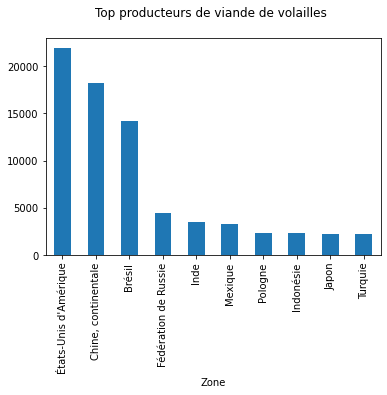

In [92]:
data['production'].sort_values(ascending=False) \
                  .head(10) \
                  .plot(kind='bar', title='Top producteurs de viande de volailles \n');

Top Chicken Meat Importers

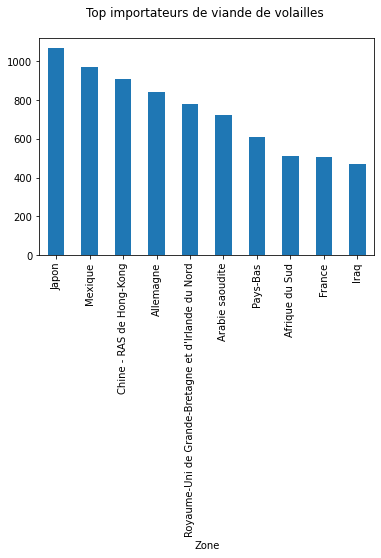

In [93]:
data['importations'].sort_values(ascending=False) \
                    .head(10) \
                    .plot(kind='bar', title='Top importateurs de viande de volailles \n');

Top Chicken Meat Exporters

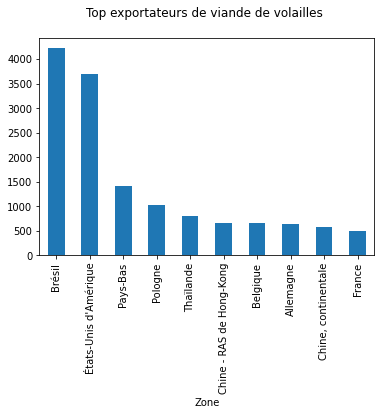

In [94]:
data['exportations'].sort_values(ascending=False) \
                    .head(10) \
                    .plot(kind='bar', title='Top exportateurs de viande de volailles \n');

Top GDP per capita

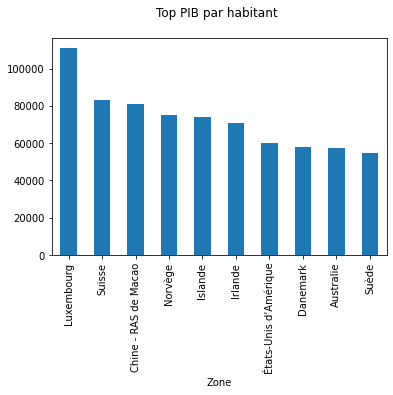

In [95]:
data['pibph'].sort_values(ascending=False) \
                    .head(10) \
                    .plot(kind='bar', title='Top PIB par habitant \n');

# 3 Data Analysis

## 3.1 Univariate Analysis

In [96]:
data.describe()

disponibilit√©_alimentaire  disponibilit√©_int√©rieure  exportations  \
count                    172.000                   172.000       172.000   
mean                      20.213                   679.599       103.750   
std                       15.860                  2175.613       458.066   
min                        0.130                     0.000         0.000   
25%                        6.440                    28.750         0.000   
50%                       18.090                    98.000         0.000   
75%                       30.038                   360.750        12.000   
max                       72.310                 18266.000      4223.000   

       importations  nourriture  pertes  production  disponibilit√©_calories  \
count       172.000     172.000 172.000     172.000                 172.000   
mean         88.488     649.407  16.977     708.326                2858.395   
std         185.825    2125.189  78.028    2474.456                 454.544   
min           0.000       0.000   0.000       0.000                1754.000   
25%           3.000      27.500   0.000      11.000                2514.250   
50%          16.000      94.500   0.000      66.000                2871.500   
75%          79.750     353.750   2.000     368.750                3250.250   
max        1069.000   18100.000 695.000   21914.000                3770.000   

       disponibilit√©_proteines  stabilit√©_politique      pibph     population  \
count                  172.000              172.000    172.000        172.000   
mean                    81.193               -0.061  14108.237   42841754.645   
std                     20.199                0.894  19367.569  153063712.477   
min                     39.910               -2.940    450.901      52045.000   
25%                     64.213               -0.623   2009.670    2874480.250   
50%                     81.390                0.015   6111.504    9757833.000   
75%                     96.445                0.650  16943.173   30138736.000   
max                    141.340                1.600 111017.182 1421021791.000   

       distance  
count   172.000  
mean   6047.144  
std    3871.626  
min     216.560  
25%    3145.744  
50%    5633.585  
75%    8654.400  
max   18932.170

On remarque quelques choses int√©ressantes par rapport aux variables exportations et pertes. Leur deuxi√®me quartile Q2 (m√©diane) est 0. Autrement dit, au moins, la moiti√© des valeurs sont 0. On va les regarder de plus pr√®s

La variable Exportations

In [97]:
data.exportations.value_counts().head(10)

0      89
1      11
4       7
2       4
10      3
6       3
3       3
115     2
23      2
44      2
Name: exportations, dtype: int64

La variable exportation contient 89 valeurs nulles. L'enlever pourrait √™tre un choix. On va essayer cependant de r√©cup√©rer m√™me une petite pi√®ce d'information. Ce qui nous int√©resse surtout est de savoir si le pays est un pays exportateur ou pas. On va cr√©er un nouvelle variable binaire ayant la valeur 1 si le pays est un pays exportateur et 0 sinon.

In [98]:
data['exportateur'] = np.where(data['exportations'] == 0, 0, 1)

In [99]:
data.exportateur.value_counts()

0    89
1    83
Name: exportateur, dtype: int64

In [100]:
data.drop(columns=['exportations'], inplace=True)

In [101]:
data.pertes.value_counts().head(10)

0      116
1       10
2        7
3        5
10       3
4        3
5        2
27       2
62       1
161      1
Name: pertes, dtype: int64

La variable pertes contient 116 valeurs nulles, autrement dit, 67% des valeurs sont 0. Elle n'apporte pas beaucoup d'informations. On va la supprimer.

In [102]:
data.drop(columns=['pertes'], inplace=True)

In [103]:
data.columns

Index(['disponibilit√©_alimentaire', 'disponibilit√©_int√©rieure', 'importations',
       'nourriture', 'production', 'disponibilit√©_calories',
       'disponibilit√©_proteines', 'stabilit√©_politique', 'pibph', 'population',
       'distance', 'exportateur'],
      dtype='object')

**Outliers Check**

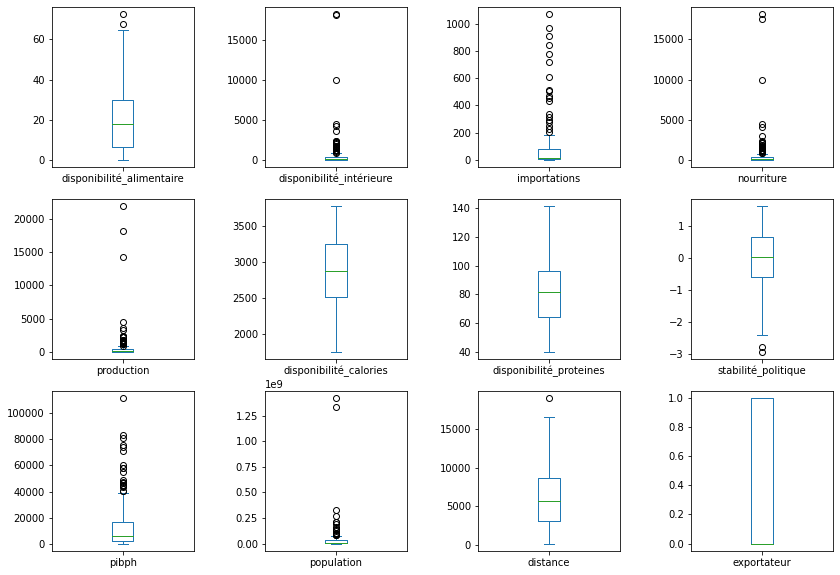

In [104]:
data.plot(kind='box', subplots=True, layout=(3, 4), figsize=(14, 10))
plt.subplots_adjust(wspace=0.5)
plt.show()

In [105]:
outliers = outliers_decector(data)
print(f"Il y a {outliers['n_outliers']} outliers au total")
print(f"Il y a {outliers['n_variables']} variables ayant des outliers")

Il y a 57 outliers au total
Il y a 9 variables ayant des outliers


In [106]:
outliers['variables']

['disponibilit√©_alimentaire',
 'disponibilit√©_int√©rieure',
 'importations',
 'nourriture',
 'production',
 'stabilit√©_politique',
 'pibph',
 'population',
 'distance']

In [107]:
outliers['indexes']

['Isra√´l',
 'Saint-Vincent-et-les Grenadines',
 'Afrique du Sud',
 'Allemagne',
 'Arabie saoudite',
 'Argentine',
 'Australie',
 'Br√©sil',
 'Canada',
 'Chine, continentale',
 'Colombie',
 'Espagne',
 'France',
 'F√©d√©ration de Russie',
 'Inde',
 'Indon√©sie',
 "Iran (R√©publique islamique d')",
 'Italie',
 'Japon',
 'Malaisie',
 'Mexique',
 'Myanmar',
 'Pakistan',
 'Philippines',
 'Pologne',
 'P√©rou',
 "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord",
 'Tha√Ølande',
 'Turquie',
 'Ukraine',
 'Viet Nam',
 '√âgypte',
 "√âtats-Unis d'Am√©rique",
 'Angola',
 'Belgique',
 'Chine - RAS de Hong-Kong',
 'Cuba',
 'Iraq',
 'Pays-Bas',
 '√âmirats arabes unis',
 'R√©publique de Cor√©e',
 'Afghanistan',
 'Y√©men',
 'Autriche',
 'Chine - RAS de Macao',
 'Danemark',
 'Finlande',
 'Irlande',
 'Islande',
 'Luxembourg',
 'Norv√®ge',
 'Nouvelle-Z√©lande',
 'Suisse',
 'Su√®de',
 'Bangladesh',
 'Nig√©ria',
 '√âthiopie']

In [108]:
for outlier in outliers['list']:
  print(f"La variable {outlier['var_name']} contient {outlier['n_outliers']} outlier(s)")
  print(outlier['outliers'], '\n')

La variable disponibilit√©_alimentaire contient 2 outlier(s)
['Isra√´l', 'Saint-Vincent-et-les Grenadines'] 

La variable disponibilit√©_int√©rieure contient 31 outlier(s)
['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Argentine', 'Australie', 'Br√©sil', 'Canada', 'Chine, continentale', 'Colombie', 'Espagne', 'France', 'F√©d√©ration de Russie', 'Inde', 'Indon√©sie', "Iran (R√©publique islamique d')", 'Italie', 'Japon', 'Malaisie', 'Mexique', 'Myanmar', 'Pakistan', 'Philippines', 'Pologne', 'P√©rou', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Tha√Ølande', 'Turquie', 'Ukraine', 'Viet Nam', '√âgypte', "√âtats-Unis d'Am√©rique"] 

La variable importations contient 19 outlier(s)
['Afrique du Sud', 'Allemagne', 'Angola', 'Arabie saoudite', 'Belgique', 'Chine - RAS de Hong-Kong', 'Chine, continentale', 'Cuba', 'Espagne', 'France', 'F√©d√©ration de Russie', 'Iraq', 'Japon', 'Mexique', 'Pays-Bas', 'Philippines', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Viet Nam'

Les 2 outliers concernant la variable stabilit√© politique (l'Afghanistan et le Y√©men) sont acutellement des zones de guerre et de conflit. Donc, ils ne seront pas des march√©es cibles. Il vaut mieux les supprimer.

In [109]:
# Supprimer les outliers de la variable stabilit√©_politique
filter = []
for outlier in outliers['list']:
  #if outlier['var_name'] in ['exportations', 'stabilit√©_politique']:
  if outlier['var_name'] in ['stabilit√©_politique']:
    for i in outlier['outliers']:
      filter.append(i)
data_filtered = data[~data.index.isin(filter)].copy()

In [110]:
data_filtered.shape

(170, 12)


**Normality Test**

Graphical Test

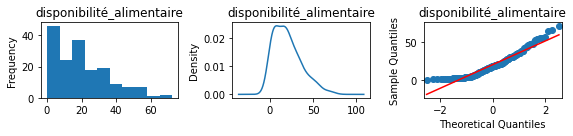

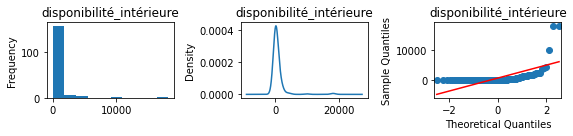

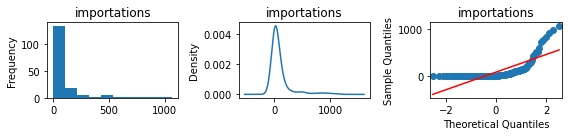

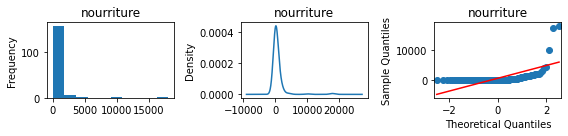

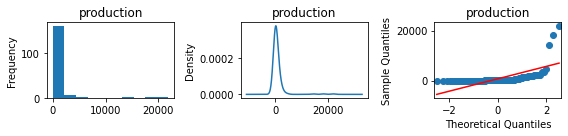

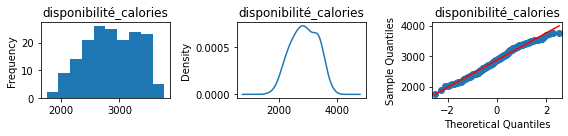

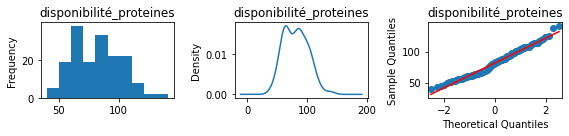

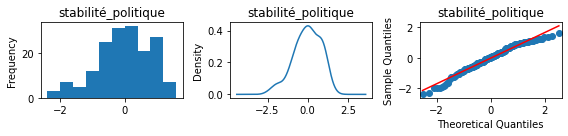

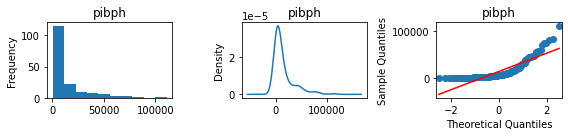

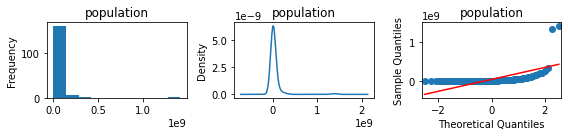

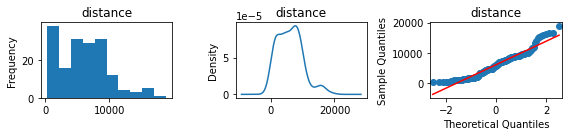

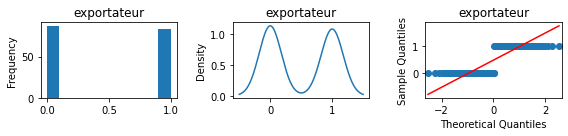

In [111]:
normality_graphical_test(data_filtered)

Statistical Test

Test de D‚ÄôAgostino et Pearson (Œ± = 0.05)

In [112]:
dagostino_test(data_filtered, 0.05)

Test de D‚ÄôAgostino et Pearson (alpha = 0.05) 

Variable : disponibilit√©_alimentaire
R√©sultat : S2 + K2 = 19.2635, p-value = 0.0001
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : disponibilit√©_int√©rieure
R√©sultat : S2 + K2 = 253.3939, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : importations
R√©sultat : S2 + K2 = 141.2625, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : nourriture
R√©sultat : S2 + K2 = 255.023, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : production
R√©sultat : S2 + K2 = 255.0359, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : disponibilit√©_calories
R√©sultat : S2 + K2 = 13.0268, p-value = 0.0015
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : disponibilit√©_proteines
R√©sultat : S2 + K2 = 4.3483, p-value = 0.1

Test de Shapiro-Wilk (Œ± = 0.05)

In [113]:
shapiro_test(data_filtered, 0.05)

Test de Shapiro-Wilk (alpha = 0.05) 

Variable : disponibilit√©_alimentaire
R√©sultat : w = 0.9259, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : disponibilit√©_int√©rieure
R√©sultat : w = 0.2985, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : importations
R√©sultat : w = 0.5145, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : nourriture
R√©sultat : w = 0.2906, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : production
R√©sultat : w = 0.2762, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : disponibilit√©_calories
R√©sultat : w = 0.9823, p-value = 0.0295
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : disponibilit√©_proteines
R√©sultat : w = 0.9805, p-value = 0.017
Interpr√©tation : la distribution semble anormale (non gaussie

On voit que la majorit√© des variables ne suivent pas la loi normale de distribution (distribution gaussienne). Cela exige un traitement particulier lors de l'analyse multivari√©e, par exemple, l'utilisation du test de corr√©lation de Spearman au lieu de Pearson. 

## 3.2 Multivariate Analysis

Correlation Test

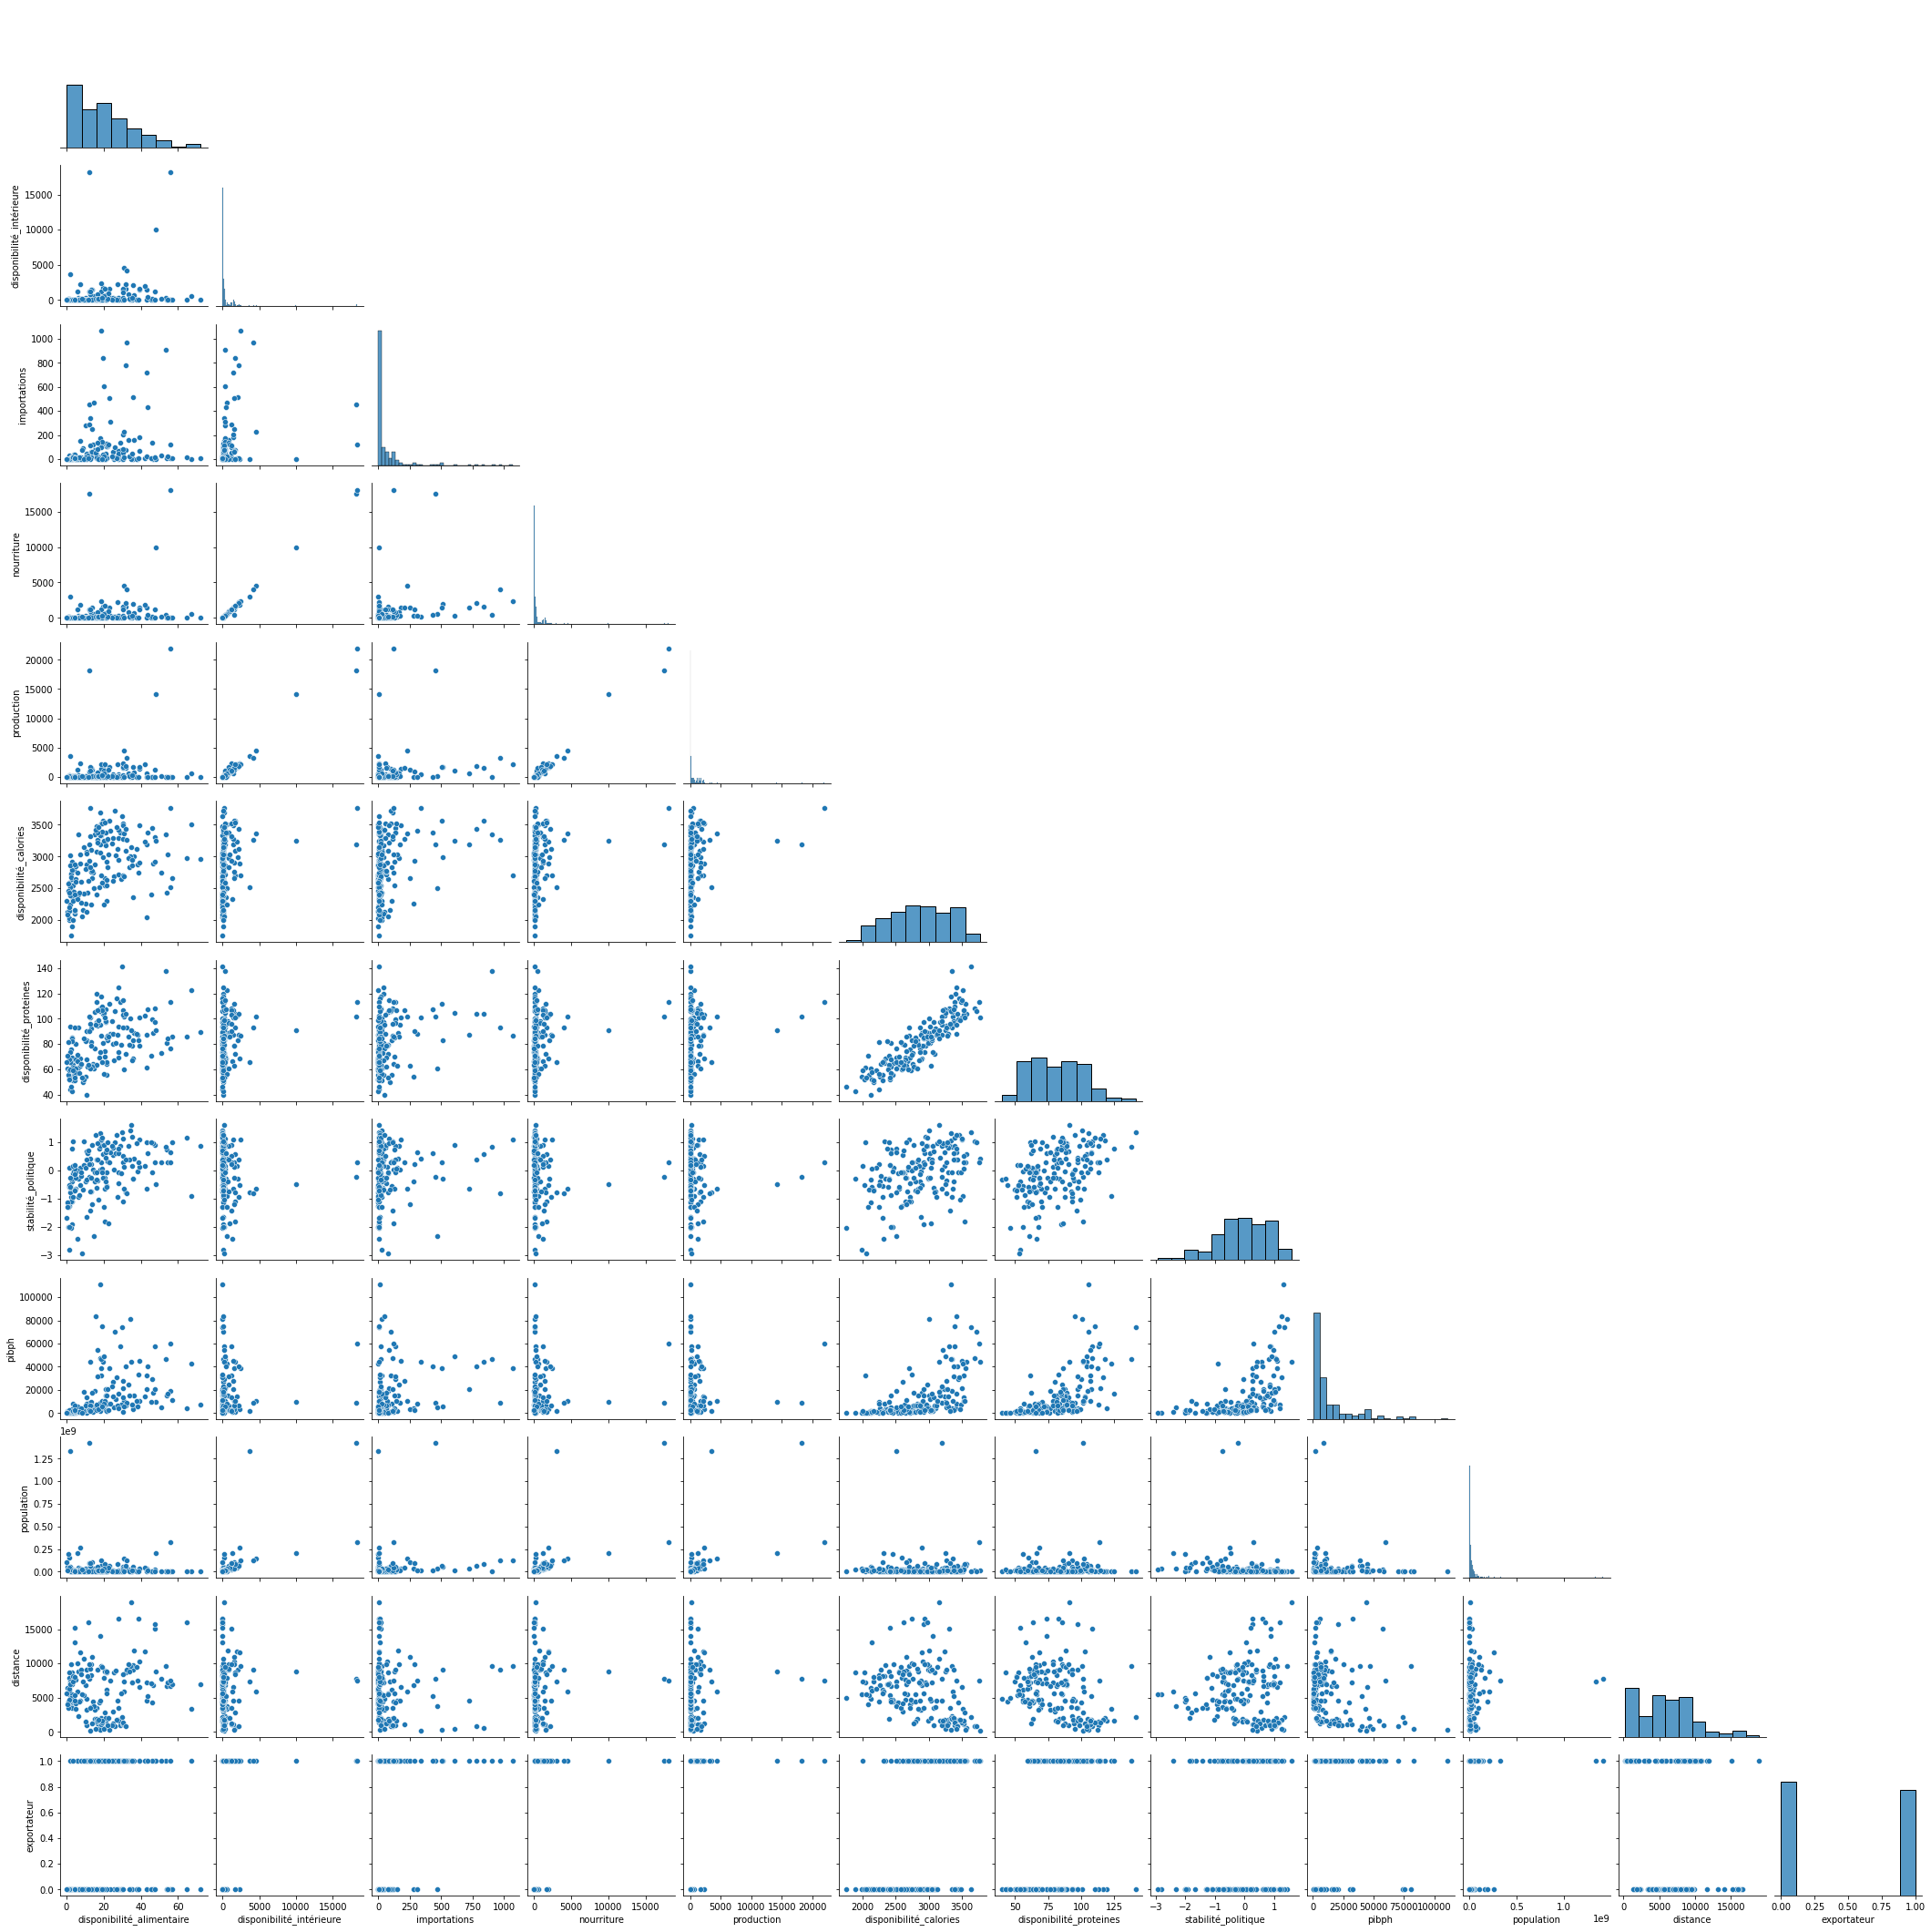

In [114]:
sns.pairplot(data=data, vars=data.columns, corner=True)
plt.show()

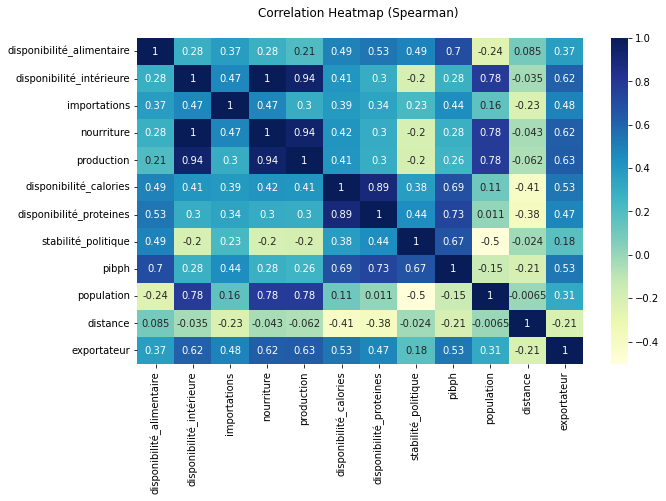

In [115]:
plt.figure(figsize=(10, 6))
sns.heatmap(data_filtered.corr(method='spearman'), annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap (Spearman) \n")
plt.show()

# 4 Data Selection

Observations üî≠

Il y a une corr√©lation tr√®s forte entre les variables : 
  - disponibilit√©_int√©rieure et nourriture (1) : Cela a beaucoup de sens puisque presque toute la viande de volailles est r√©serv√©e aux consommateurs humains.
  - disponibilit√©_int√©rieure et production (0.94) : Logique, la production va augmenter le disponibilit√© et vice versa.
  - production et nourriture (0.94)
  - disponibilit√©_proteines et disponibilit√©_calories (0.89)

On va supprimer les variables fortement corr√©l√©es, √† savoir, la disponibilit√©_int√©rieure, la nourriture et la disponibilit√©_prot√©ine

In [116]:
# Supprimer les varaibles corr√©l√©es
var_supprimer = ['disponibilit√©_int√©rieure', 'nourriture', 'disponibilit√©_proteines']
cols = [column for column in data_filtered.columns if column not in var_supprimer]
data_clean = data_filtered[cols].copy()

In [117]:
data_clean.head()

disponibilit√©_alimentaire  importations  production  \
Zone                                                                  
Afrique du Sud                     35.690           514        1667   
Albanie                            16.360            38          13   
Alg√©rie                             6.380             2         275   
Allemagne                          19.470           842        1514   
Angola                             10.560           277          42   

                disponibilit√©_calories  stabilit√©_politique     pibph  \
Zone                                                                    
Afrique du Sud                    2987               -0.280  6121.877   
Albanie                           3400                0.380  4514.205   
Alg√©rie                           3345               -0.920  4109.696   
Allemagne                         3559                0.590 44651.829   
Angola                            2266               -0.380  4095.812   

                population  distance  exportateur  
Zone                                               
Afrique du Sud    57009756  9076.306            1  
Albanie            2884169  1630.739            0  
Alg√©rie           41389189  2333.470            0  
Allemagne         82658409   613.005            1  
Angola            29816766  6862.122            0

In [118]:
data_clean.shape

(170, 9)

Puisqu'on parle d'une expansion √† l'international, la France ne peut pas √™tre un pays cible. On va donc l'enlever.

In [119]:
data_clean = data_clean[data_clean.index != 'France'].copy()

# 5 Data Transformation

On va essayer d'enlever les outliers en utilisant quelques transformations. Cela peut √©galement normaliser la distribution de certaines variables. 

In [120]:
df = data_clean.copy()

## 5.1 Custom transformation

On commence par appliquer une transformation personnalis√©e. On va utiliser surtout la transformation logarithmique et la transformation racine carr√©e pour transformer les variables ayant des outliers et ne suivant pas la loi normal de distribution.

Voici une liste des variables affect√©es avec le type de transformation appliqu√©e : 

Transformation racine carr√©e :
- disponibilit√©_alimentaire
- disponibilit√©_calories
- distance

Transformation logarithmique (Log10)
- production
- importations
- population
- pibph


In [121]:
df['production_t'] = np.where(df['production'] == 0, 0, np.log10(df['production']))
df['importations_t'] = np.where(df['importations'] == 0, 0, np.log10(df['importations']))
df['disponibilit√©_alimentaire_t'] = np.sqrt(df['disponibilit√©_alimentaire'])
df['disponibilit√©_calories_t'] = np.sqrt(df['disponibilit√©_calories'])
df['population_t'] = np.log10(df['population'])
df['pibph_t'] = np.log10(df['pibph'])
df['distance_t'] = np.sqrt(df['distance'])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [122]:
df.head()

disponibilit√©_alimentaire  importations  production  \
Zone                                                                  
Afrique du Sud                     35.690           514        1667   
Albanie                            16.360            38          13   
Alg√©rie                             6.380             2         275   
Allemagne                          19.470           842        1514   
Angola                             10.560           277          42   

                disponibilit√©_calories  stabilit√©_politique     pibph  \
Zone                                                                    
Afrique du Sud                    2987               -0.280  6121.877   
Albanie                           3400                0.380  4514.205   
Alg√©rie                           3345               -0.920  4109.696   
Allemagne                         3559                0.590 44651.829   
Angola                            2266               -0.380  4095.812   

                population  distance  exportateur  production_t  \
Zone                                                              
Afrique du Sud    57009756  9076.306            1         3.222   
Albanie            2884169  1630.739            0         1.114   
Alg√©rie           41389189  2333.470            0         2.439   
Allemagne         82658409   613.005            1         3.180   
Angola            29816766  6862.122            0         1.623   

                importations_t  disponibilit√©_alimentaire_t  \
Zone                                                          
Afrique du Sud           2.711                        5.974   
Albanie                  1.580                        4.045   
Alg√©rie                  0.301                        2.526   
Allemagne                2.925                        4.412   
Angola                   2.442                        3.250   

                disponibilit√©_calories_t  population_t  pibph_t  distance_t  
Zone                                                                         
Afrique du Sud                    54.653         7.756    3.787      95.270  
Albanie                           58.310         6.460    3.655      40.382  
Alg√©rie                           57.836         7.617    3.614      48.306  
Allemagne                         59.657         7.917    4.650      24.759  
Angola                            47.603         7.474    3.612      82.838

In [123]:
cols = [x for x in df.columns if x.endswith('_t')]
cols.append('stabilit√©_politique')
cols

['production_t',
 'importations_t',
 'disponibilit√©_alimentaire_t',
 'disponibilit√©_calories_t',
 'population_t',
 'pibph_t',
 'distance_t',
 'stabilit√©_politique']

In [124]:
data_transformed = df[cols].copy()
data_transformed.head()

production_t  importations_t  disponibilit√©_alimentaire_t  \
Zone                                                                        
Afrique du Sud         3.222           2.711                        5.974   
Albanie                1.114           1.580                        4.045   
Alg√©rie                2.439           0.301                        2.526   
Allemagne              3.180           2.925                        4.412   
Angola                 1.623           2.442                        3.250   

                disponibilit√©_calories_t  population_t  pibph_t  distance_t  \
Zone                                                                          
Afrique du Sud                    54.653         7.756    3.787      95.270   
Albanie                           58.310         6.460    3.655      40.382   
Alg√©rie                           57.836         7.617    3.614      48.306   
Allemagne                         59.657         7.917    4.650      24.759   
Angola                            47.603         7.474    3.612      82.838   

                stabilit√©_politique  
Zone                                 
Afrique du Sud               -0.280  
Albanie                       0.380  
Alg√©rie                      -0.920  
Allemagne                     0.590  
Angola                       -0.380

Allons rev√©rifier les outliers

**Outliers Check**

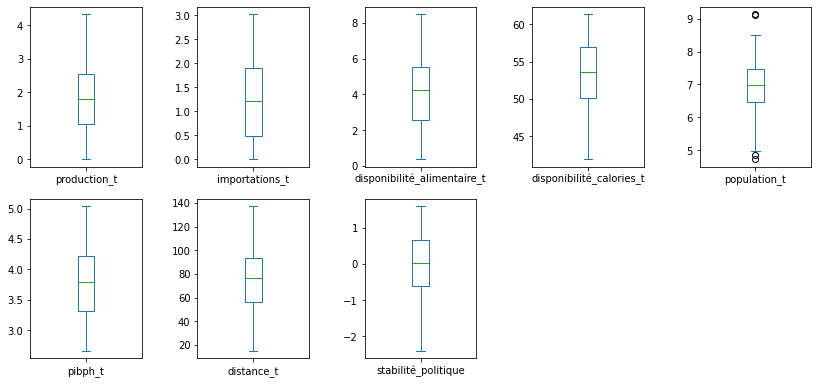

In [125]:
data_transformed.plot(kind='box', subplots=True, layout=(3, 5), figsize=(14, 10))
plt.subplots_adjust(wspace=0.5)
plt.show()

In [126]:
outliers = outliers_decector(data_transformed)
print(f"Il y a {outliers['n_outliers']} outliers au total")
print(f"Il y a {outliers['n_variables']} variables ayant des outliers")
print(outliers['variables'])

Il y a 4 outliers au total
Il y a 1 variables ayant des outliers
['population_t']


In [127]:
for outlier in outliers['list']:
  print(f"La variable {outlier['var_name']} contient {outlier['n_outliers']} outlier(s)")
  print(outlier['outliers'], '\n')

La variable population_t contient 4 outlier(s)
['Chine, continentale', 'Dominique', 'Inde', 'Saint-Kitts-et-Nevis'] 



La transformation personnalis√©e n'a pas r√©ussi √† enlever tous les outliers. V√©rifions maintenant la distribution des variables.  

**Normality Test**

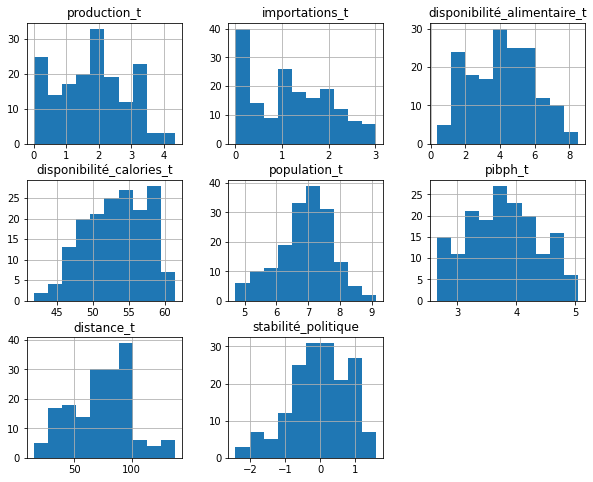

In [128]:
data_transformed.hist(figsize=(10, 8))
plt.show()

In [129]:
dagostino_test(data_transformed, 0.05)

Test de D‚ÄôAgostino et Pearson (alpha = 0.05) 

Variable : production_t
R√©sultat : S2 + K2 = 8.3739, p-value = 0.0152
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : importations_t
R√©sultat : S2 + K2 = 24.815, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : disponibilit√©_alimentaire_t
R√©sultat : S2 + K2 = 9.9256, p-value = 0.007
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : disponibilit√©_calories_t
R√©sultat : S2 + K2 = 8.9789, p-value = 0.0112
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : population_t
R√©sultat : S2 + K2 = 2.4754, p-value = 0.29
Interpr√©tation : la distribution semble normale (gaussienne) 

Variable : pibph_t
R√©sultat : S2 + K2 = 16.0466, p-value = 0.0003
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : distance_t
R√©sultat : S2 + K2 = 3.777, p-value = 0.1513
Interpr√©tation : la distri

In [130]:
shapiro_test(data_transformed, 0.05)

Test de Shapiro-Wilk (alpha = 0.05) 

Variable : production_t
R√©sultat : w = 0.9662, p-value = 0.0004
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : importations_t
R√©sultat : w = 0.9492, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : disponibilit√©_alimentaire_t
R√©sultat : w = 0.98, p-value = 0.0154
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : disponibilit√©_calories_t
R√©sultat : w = 0.9802, p-value = 0.0162
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : population_t
R√©sultat : w = 0.9849, p-value = 0.0637
Interpr√©tation : la distribution semble normale (gaussienne) 

Variable : pibph_t
R√©sultat : w = 0.9782, p-value = 0.0091
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : distance_t
R√©sultat : w = 0.9756, p-value = 0.0044
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable :

On voit que la transformation personnalis√©e n'a pas non plus r√©ussi √† normaliser la distibution de certaines varialbes. On va donc essayer des autres transformations. 

## 5.2 Yeo-Johnson transform

In [131]:
df = data_clean.copy()

In [132]:
df.columns

Index(['disponibilit√©_alimentaire', 'importations', 'production',
       'disponibilit√©_calories', 'stabilit√©_politique', 'pibph', 'population',
       'distance', 'exportateur'],
      dtype='object')

In [133]:
df.describe()

disponibilit√©_alimentaire  importations  production  \
count                    169.000       169.000     169.000   
mean                      20.377        86.432     709.385   
std                       15.909       184.618    2494.257   
min                        0.130         0.000       0.000   
25%                        6.460         3.000      11.000   
50%                       18.200        16.000      65.000   
75%                       30.300        79.000     361.000   
max                       72.310      1069.000   21914.000   

       disponibilit√©_calories  stabilit√©_politique      pibph     population  \
count                 169.000              169.000    169.000        169.000   
mean                 2864.077               -0.030  14122.073   42839102.710   
std                   446.295                0.847  19391.574  154409810.038   
min                  1754.000               -2.410    450.901      52045.000   
25%                  2517.000               -0.610   2074.175    2845414.000   
50%                  2872.000                0.030   6121.877    9487203.000   
75%                  3250.000                0.650  16784.460   29402484.000   
max                  3770.000                1.600 111017.182 1421021791.000   

       distance  exportateur  
count   169.000      169.000  
mean   6087.149        0.485  
std    3880.271        0.501  
min     216.560        0.000  
25%    3210.925        0.000  
50%    5871.479        0.000  
75%    8665.694        1.000  
max   18932.170        1.000

In [134]:
X = df.values
zones = df.index
features = df.columns

In [135]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [136]:
yj = PowerTransformer(method = 'yeo-johnson')
X_trans = yj.fit_transform(X_scaled)

In [137]:
data_trans_yj = pd.DataFrame(X_trans)
data_trans_yj.columns = features
data_trans_yj.index = zones

In [138]:
data_trans_yj.head()

disponibilit√©_alimentaire  importations  production  \
Zone                                                                  
Afrique du Sud                      1.045         1.958       1.869   
Albanie                            -0.066         0.151      -0.755   
Alg√©rie                            -0.956        -0.888       0.267   
Allemagne                           0.163         2.018       1.820   
Angola                             -0.556         1.790      -0.620   

                disponibilit√©_calories  stabilit√©_politique  pibph  \
Zone                                                                 
Afrique du Sud                   0.251               -0.396 -0.219   
Albanie                          1.221                0.420 -0.473   
Alg√©rie                          1.089               -1.059 -0.541   
Allemagne                        1.603                0.711  1.616   
Angola                          -1.324               -0.506 -0.543   

                population  distance  exportateur  
Zone                                               
Afrique du Sud       1.439     0.845        1.030  
Albanie             -0.824    -1.273       -0.971  
Alg√©rie              1.095    -1.025       -0.971  
Allemagne            1.761    -1.647        1.030  
Angola               0.714     0.337       -0.971

In [139]:
data_trans_yj.describe()

disponibilit√©_alimentaire  importations  production  \
count                    169.000       169.000     169.000   
mean                       0.000        -0.000       0.000   
std                        1.003         1.003       1.003   
min                       -1.624        -0.960      -0.817   
25%                       -0.948        -0.853      -0.764   
50%                        0.073        -0.432      -0.517   
75%                        0.794         0.878       0.517   
max                        2.277         2.034       2.125   

       disponibilit√©_calories  stabilit√©_politique   pibph  population  \
count                 169.000              169.000 169.000     169.000   
mean                    0.000               -0.000  -0.000      -0.000   
std                     1.003                1.003   1.003       1.003   
min                    -2.383               -2.367  -1.245      -1.056   
25%                    -0.790               -0.749  -0.913      -0.827   
50%                    -0.010               -0.034  -0.219      -0.342   
75%                     0.864                0.797   0.853       0.698   
max                     2.118                2.276   1.986       2.217   

       distance  exportateur  
count   169.000      169.000  
mean     -0.000        0.000  
std       1.003        1.003  
min      -1.797       -0.971  
25%      -0.727       -0.971  
50%       0.079       -0.971  
75%       0.757        1.030  
max       2.582        1.030

**Outliers Check**

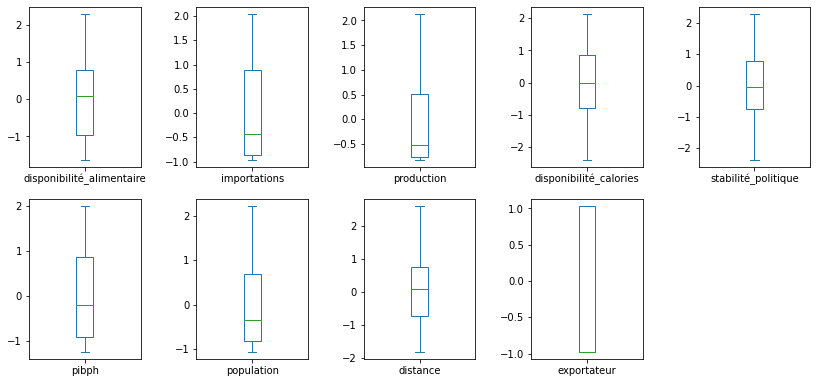

In [140]:
data_trans_yj.plot(kind='box', subplots=True, layout=(3, 5), figsize=(14, 10))
plt.subplots_adjust(wspace=0.5)
plt.show()

In [141]:
outliers = outliers_decector(data_trans_yj)
print(f"Il y a {outliers['n_outliers']} outliers au total")

Il y a 0 outliers au total


Super! On voit tr√®s bien que la transformation de Yeo-Johnson a bien enlev√© tous les outliers. Allons v√©rifier son impact sur la distribution.

**Normality Test**

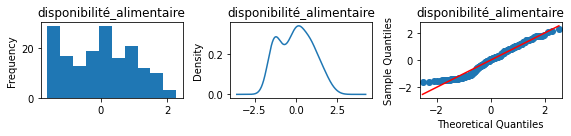

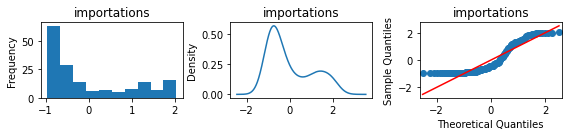

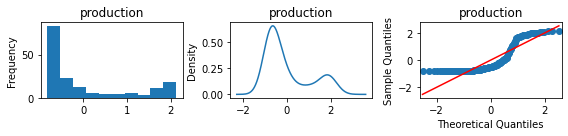

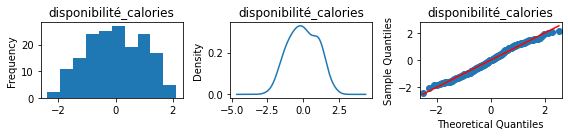

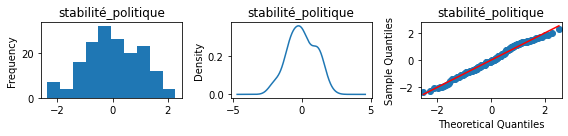

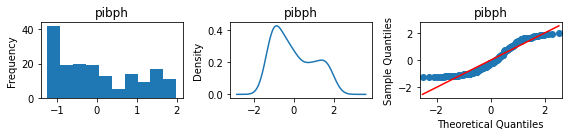

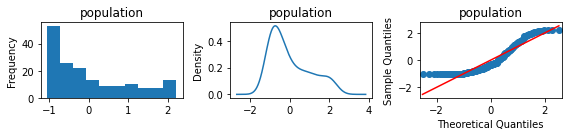

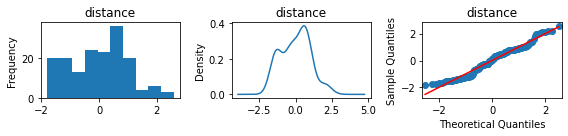

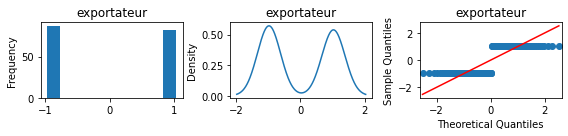

In [142]:
for col in data_trans_yj.columns:
    fig, axes = plt.subplots(1, 3, figsize = (8, 2))
    data_trans_yj[col].plot(kind='hist', ax = axes[0]);
    data_trans_yj[col].plot(kind='kde', ax = axes[1]);
    axes[0].set_title(col)
    axes[1].set_title(col)
    
    qqplot(data_trans_yj[col], line='s', ax = axes[2])
    plt.title(col)
    fig.tight_layout()
    plt.show()

In [143]:
dagostino_test(data_trans_yj, 0.05)

Test de D‚ÄôAgostino et Pearson (alpha = 0.05) 

Variable : disponibilit√©_alimentaire
R√©sultat : S2 + K2 = 25.134, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : importations
R√©sultat : S2 + K2 = 31.6192, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : production
R√©sultat : S2 + K2 = 26.5579, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : disponibilit√©_calories
R√©sultat : S2 + K2 = 13.5022, p-value = 0.0012
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : stabilit√©_politique
R√©sultat : S2 + K2 = 5.0543, p-value = 0.0799
Interpr√©tation : la distribution semble normale (gaussienne) 

Variable : pibph
R√©sultat : S2 + K2 = 58.0879, p-value = 0.0
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : population
R√©sultat : S2 + K2 = 20.3688, p-value = 0.0
Interpr√©tation : la distribution

On aper√ßoit que la transformation de Yeo-Johnson n'a pas r√©ussi √† normaliser la distribution des variables anormales. Donc, on va essayer une derin√®re transformation, Celle de Box-Cox. 

## 5.3 Box-Cox trasform

In [144]:
df = data_clean.copy()

In [145]:
df.columns

Index(['disponibilit√©_alimentaire', 'importations', 'production',
       'disponibilit√©_calories', 'stabilit√©_politique', 'pibph', 'population',
       'distance', 'exportateur'],
      dtype='object')

In [146]:
df.describe()

disponibilit√©_alimentaire  importations  production  \
count                    169.000       169.000     169.000   
mean                      20.377        86.432     709.385   
std                       15.909       184.618    2494.257   
min                        0.130         0.000       0.000   
25%                        6.460         3.000      11.000   
50%                       18.200        16.000      65.000   
75%                       30.300        79.000     361.000   
max                       72.310      1069.000   21914.000   

       disponibilit√©_calories  stabilit√©_politique      pibph     population  \
count                 169.000              169.000    169.000        169.000   
mean                 2864.077               -0.030  14122.073   42839102.710   
std                   446.295                0.847  19391.574  154409810.038   
min                  1754.000               -2.410    450.901      52045.000   
25%                  2517.000               -0.610   2074.175    2845414.000   
50%                  2872.000                0.030   6121.877    9487203.000   
75%                  3250.000                0.650  16784.460   29402484.000   
max                  3770.000                1.600 111017.182 1421021791.000   

       distance  exportateur  
count   169.000      169.000  
mean   6087.149        0.485  
std    3880.271        0.501  
min     216.560        0.000  
25%    3210.925        0.000  
50%    5871.479        0.000  
75%    8665.694        1.000  
max   18932.170        1.000

In [147]:
max = df['stabilit√©_politique'].max()
min = df['stabilit√©_politique'].min()
df['stabilit√©_politique_t'] = (df['stabilit√©_politique'] - min) / (max - min)

In [148]:
df.drop(columns=['stabilit√©_politique'], inplace=True)

In [149]:
# Remplacer les 0 par 0,000001 car box-cox n'accepte pas des 0
df.replace(0, 0.000001, inplace=True)

In [150]:
df.head()

disponibilit√©_alimentaire  importations  production  \
Zone                                                                  
Afrique du Sud                     35.690       514.000    1667.000   
Albanie                            16.360        38.000      13.000   
Alg√©rie                             6.380         2.000     275.000   
Allemagne                          19.470       842.000    1514.000   
Angola                             10.560       277.000      42.000   

                disponibilit√©_calories     pibph  population  distance  \
Zone                                                                     
Afrique du Sud                    2987  6121.877    57009756  9076.306   
Albanie                           3400  4514.205     2884169  1630.739   
Alg√©rie                           3345  4109.696    41389189  2333.470   
Allemagne                         3559 44651.829    82658409   613.005   
Angola                            2266  4095.812    29816766  6862.122   

                exportateur  stabilit√©_politique_t  
Zone                                                
Afrique du Sud        1.000                  0.531  
Albanie               0.000                  0.696  
Alg√©rie               0.000                  0.372  
Allemagne             1.000                  0.748  
Angola                0.000                  0.506

In [151]:
X = df.values
zones = df.index
features = df.columns

In [152]:
bc = PowerTransformer(method = 'box-cox')
bc.fit(X)
X_trans = bc.transform(X)

In [153]:
data_trans_bc = pd.DataFrame(X_trans)
data_trans_bc.columns = features
data_trans_bc.index = zones

In [154]:
data_trans_bc.head()

disponibilit√©_alimentaire  importations  production  \
Zone                                                                  
Afrique du Sud                      0.995         1.696       1.310   
Albanie                             0.012         0.362      -0.515   
Alg√©rie                            -0.834        -0.590       0.485   
Allemagne                           0.206         2.021       1.260   
Angola                             -0.420         1.325      -0.180   

                disponibilit√©_calories  pibph  population  distance  \
Zone                                                                  
Afrique du Sud                   0.263  0.023       1.031     0.829   
Albanie                          1.214 -0.200      -0.554    -1.257   
Alg√©rie                          1.086 -0.268       0.850    -0.957   
Allemagne                        1.586  1.448       1.245    -1.846   
Angola                          -1.334 -0.271       0.667     0.355   

                exportateur  stabilit√©_politique_t  
Zone                                                
Afrique du Sud        1.030                 -0.312  
Albanie              -0.971                  0.480  
Alg√©rie              -0.971                 -1.065  
Allemagne             1.030                  0.735  
Angola               -0.971                 -0.431

**Outliers Check**

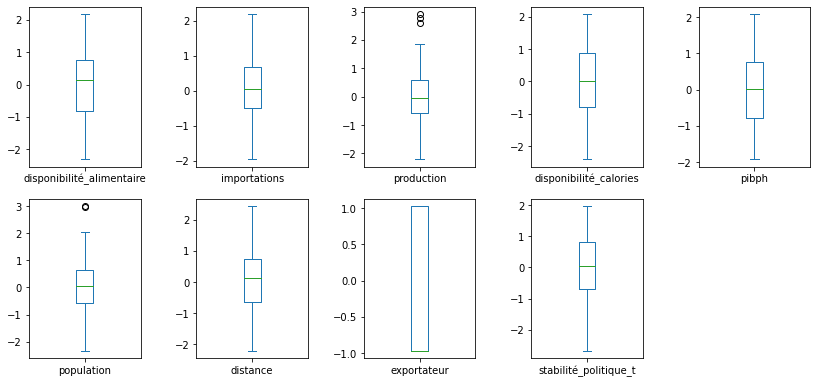

In [155]:
data_trans_bc.plot(kind='box', subplots=True, layout=(3, 5), figsize=(14, 10))
plt.subplots_adjust(wspace=0.5)
plt.show()

In [156]:
outliers = outliers_decector(data_trans_bc)
print(f"Il y a {outliers['n_outliers']} outliers au total")
print(f"Il y a {outliers['n_variables']} variables ayant des outliers")
print(outliers['variables'])

Il y a 4 outliers au total
Il y a 2 variables ayant des outliers
['production', 'population']


In [157]:
for outlier in outliers['list']:
  print(f"La variable {outlier['var_name']} contient {outlier['n_outliers']} outlier(s)")
  print(outlier['outliers'], '\n')

La variable production contient 3 outlier(s)
['Br√©sil', 'Chine, continentale', "√âtats-Unis d'Am√©rique"] 

La variable population contient 2 outlier(s)
['Chine, continentale', 'Inde'] 



Le resultat de la transformation de Box-Cox est moins int√©ressant de celle de Yeo-johnson en ce qui cencerne les outliers. Effictivement, elle a laiss√© quelques outliers. V√©rifions si elle a fait un bon travail pour normaliser la distribution des variables.  

**Normality Test**

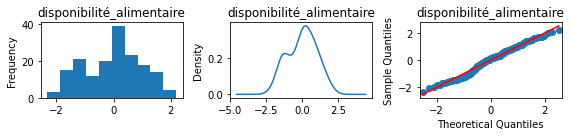

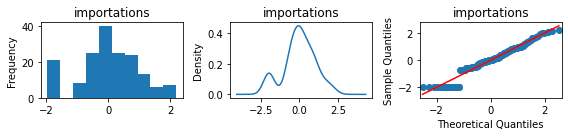

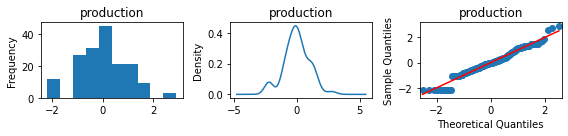

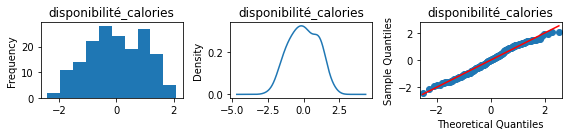

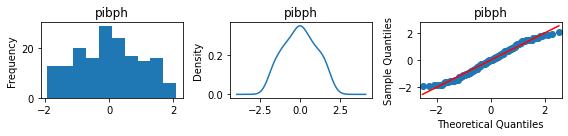

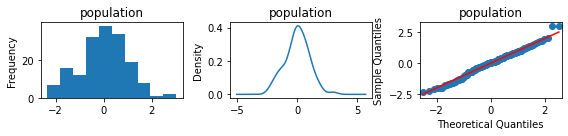

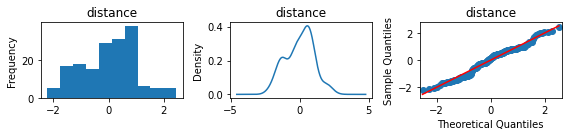

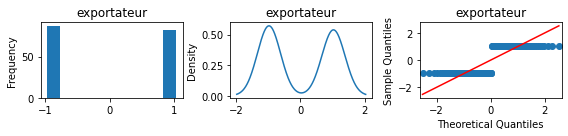

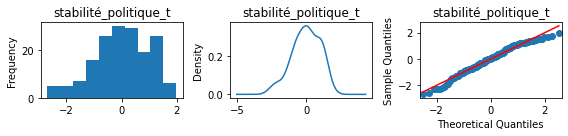

In [158]:
normality_graphical_test(data_trans_bc)

In [159]:
dagostino_test(data_trans_bc, 0.05)

Test de D‚ÄôAgostino et Pearson (alpha = 0.05) 

Variable : disponibilit√©_alimentaire
R√©sultat : S2 + K2 = 10.5753, p-value = 0.0051
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : importations
R√©sultat : S2 + K2 = 2.9783, p-value = 0.2256
Interpr√©tation : la distribution semble normale (gaussienne) 

Variable : production
R√©sultat : S2 + K2 = 1.9475, p-value = 0.3777
Interpr√©tation : la distribution semble normale (gaussienne) 

Variable : disponibilit√©_calories
R√©sultat : S2 + K2 = 13.5464, p-value = 0.0011
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : pibph
R√©sultat : S2 + K2 = 16.1945, p-value = 0.0003
Interpr√©tation : la distribution semble anormale (non gaussienne) 

Variable : population
R√©sultat : S2 + K2 = 0.3451, p-value = 0.8415
Interpr√©tation : la distribution semble normale (gaussienne) 

Variable : distance
R√©sultat : S2 + K2 = 3.6859, p-value = 0.1583
Interpr√©tation : la distribution semble n

Alors que la transformation de Box-Cox a effictivement r√©ussi √† normaliser certaines variables, elle a laiss√© quelques outliers. Le fait que l'existence des outliers a un impact plus grave sur les algorithmes de clustering et de classification que l'on va mise en oeurvre dans la deuxi√®me partie, on pr√©f√®re toujours avoir un jeu de donn√©es sans outliers. On va donc retenir la transoformation de Yeo-Johnson pour la deuxi√®me partie.

# 6 Data Export

In [160]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/p9_data.csv')
data_clean.to_csv('/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/p9_data_clean.csv')
data_transformed.to_csv('/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/p9_data_transformed.csv')
data_trans_bc.to_csv('/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/p9_data_trans_bc.csv')
data_trans_yj.to_csv('/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/p9_data_trans_yj.csv')